In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
import sys
print(sys.executable)

'/Users/adminpc-macmini/Documents/Code/Libaries/python_jupyter_venv/bin/python'

In [5]:
!jupyter kernelspec list

Available kernels:
  python3    /Users/adminpc-macmini/Documents/Code/Libaries/python_jupyter_venv/share/jupyter/kernels/python3


In [44]:
import glob
# import imageio as iio
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd

In [7]:
from skimage import color
from skimage import io

In [8]:
ROOT_FILE_PATH = "/Users/adminpc-macmini/Library/CloudStorage/GoogleDrive-jeremias.rueck@gmail.com/Meine Ablage/Google Drive - Code/NTHU/final_project/data"
AREAS = ["prf-visualrois", "floc-bodies", "floc-faces", "floc-places", "floc-words", "streams", "all-vertices"]
SUBJ_LIST = ["subj01", "subj02", "subj03", "subj04", "subj05", "subj06", "subj07", "subj08"]
MASK_KEYS = ["lh.fsaverage_space", "rh.fsaverage_space", "lh.space", "rh.space", "mapping"]

In [9]:
def ReadNpyFile(dir_path):
  return_dic = {}
  for path in glob.glob(dir_path + "/*.npy"):
    filename = os.path.splitext(path)[0].split("/")[-1]
    return_dic[filename] = np.load(path, allow_pickle = True)
  return return_dic

def ReadFmriFile(dir_path):
  return_dic = {}
  for path in glob.glob(dir_path + "/*.npy"):
    filename = os.path.splitext(path)[0].split("/")[-1]
    return_dic[filename[0]] = np.load(path, allow_pickle = True)
  return return_dic

def ReadMaskFile(dir_path):
  return_dic = {area: {} for area in AREAS}
  for path in glob.glob(dir_path + "/*.npy"):
    filename = os.path.splitext(path)[0].split("/")[-1]
    for area in AREAS:
      if area in filename:
        filename = "".join(i.strip("_") for i in filename.split(area))
        return_dic[area][filename] = np.load(path, allow_pickle = True) if filename[0] != "m" else np.load(path, allow_pickle = True).item()
        break
  return return_dic

def FetchPngFile(dir_path, index, mode = "rgb"):
  # img = iio.v3.imread()
  img = io.imread(os.path.join(dir_path, f'{index}.png'))
  if mode == "rgb":
    return img
  if mode == "hsv":
    return color.rgb2hsv(img)
    # return matplotlib.colors.rgb_to_hsv(img)
  if mode == "gray":
    return color.rgb2gray(img)
    # return np.dot(img, [0.299, 0.587, 0.114])

In [10]:
def train_val_split(x, y, ratio, random_state=42):
  
  r = np.random.RandomState(random_state)
  
  idx = r.permutation(x.index)
  x_per = x.reindex(idx)
  y_per = y.reindex(idx)

  train_size = int(x.shape[0] * ratio)
  
  x_train = x_per[0:train_size]
  y_train = y_per[0:train_size]
  
  x_val = x_per[train_size:]
  y_val = y_per[train_size:]
  
  print('Training_dimension: ' + str(x_train.shape) + ' | ' + str(y_train.shape))
  print('Validation_dimension: ' + str(x_val.shape) + ' | ' + str(y_val.shape))

  return x_train, x_val, y_train, y_val

In [11]:
class ReadObject:
  
  fmri = None           # dict(string -> ndarray, float32)
  masks = None          # dict(string "AREA" -> (dict(int -> string), string "HEMISPHERE, " -> ndarray))
  
  image_labels = None   # dataframe
  label_names = None    # list

  subject = None        # string
  
  def __init__(self, subject):
    self.subject = subject

  # Mode = "train" | "test"
  def load(self, mode = "train"):
    
    self.image_labels = pd.read_csv(os.path.join(ROOT_FILE_PATH, "image_infos", f"{self.subject}_infos_train.csv"))
    self.image_labels = self.image_labels.drop(self.image_labels.columns[[0, 1]], axis=1)
    self.label_names = self.image_labels.columns
    
    self.image_labels = self.image_labels.to_numpy(dtype=int)

    print('Images: ' + str(self.image_labels.shape[0]))
    print('Labels: ' + str(self.image_labels.shape[1]))
    
    self.masks = ReadMaskFile(os.path.join(ROOT_FILE_PATH, self.subject , "roi_masks"))
    print('Masks: ' + str(len(self.masks.keys())))
        
    if mode == "train":
      self.fmri = ReadFmriFile(os.path.join(ROOT_FILE_PATH, self.subject, "training_split", "training_fmri"))
    elif mode == "test":
      self.fmri = ReadFmriFile(os.path.join(ROOT_FILE_PATH, self.subject, "test_split", "test_fmri"))

  def split_data(self, count=None, ratio=None, permutate=True, image_mode = "rgb", random_state=42):
    
    if ratio is None:
      ratio = 1
    
    random_state = np.random.RandomState(random_state)
    
    if count is not None and count > 0:
      fmri_l_copy = self.fmri['l'][:count]
      fmri_r_copy = self.fmri['r'][:count]
      labels_copy = self.image_labels[:count]
    else:
      fmri_l_copy = self.fmri['l']
      fmri_r_copy = self.fmri['r']
      labels_copy = self.image_labels
    
    loaded_images = np.stack([FetchPngFile(os.path.join(ROOT_FILE_PATH, self.subject,
                      "training_split", "training_images"), i, mode = image_mode) for i in range(labels_copy.shape[0])])
    
    if permutate:
      
        idx = random_state.permutation(labels_copy.shape[0])
        
        fmri_l_copy = fmri_l_copy[idx]
        fmri_r_copy = fmri_r_copy[idx]
        labels_copy = labels_copy[idx]
        loaded_images = loaded_images[idx]
        
    train_size = int(labels_copy.shape[0] * ratio)
  
    fmri_l_train = fmri_l_copy[0:train_size]
    fmri_r_train = fmri_r_copy[0:train_size]
    labels_train = labels_copy[0:train_size]
    images_train = loaded_images[0:train_size]
    
    fmri_l_val = fmri_l_copy[train_size:]
    fmri_r_val = fmri_r_copy[train_size:]
    labels_val = labels_copy[train_size:]
    images_val = loaded_images[train_size:]
    
    return (labels_train, labels_val), (fmri_l_train, fmri_l_val), (fmri_r_train, fmri_r_val), (images_train, images_val)

In [42]:
%matplotlib inline
def test_data(label_names, labels_list, image, fmri_l, fmri_r):
  labels = np.array(label_names)[np.where(labels_list != 0)] 
  print(labels)
  imgplot = plt.imshow(image)
  plt.show()

In [12]:
obj = ReadObject(SUBJ_LIST[0]) 
obj.load()

Images: 5000
Labels: 133
Masks: 7


In [13]:
(
  (labels_train, labels_val), (fmri_l_train, fmri_l_val), 
  (fmri_r_train, fmri_r_val), (images_train, images_val)
) = (obj.split_data(count=5000, ratio=0.995, image_mode= "rgb"))

In [14]:
print(labels_train.shape)
print(labels_val.shape)
print(fmri_l_train.shape)
print(fmri_l_val.shape)
print(fmri_r_train.shape)
print(fmri_r_val.shape)
print(images_train.shape)
print(images_val.shape)

(4975, 133)
(25, 133)
(4975, 19004)
(25, 19004)
(4975, 20544)
(25, 20544)
(4975, 425, 425, 3)
(25, 425, 425, 3)


['bottle' 'cup' 'sink' 'toothbrush' 'door-stuff' 'wall-tile'
 'floor-other-merged']


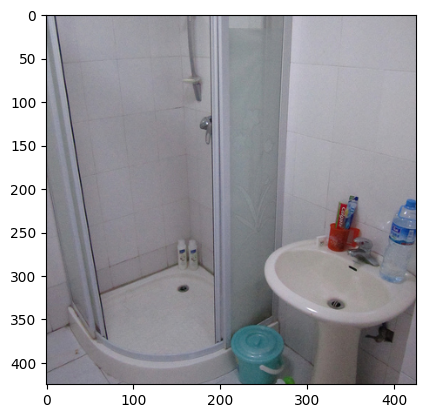

In [49]:
index = 182
test_data(obj.label_names, labels_train[index], images_train[index], None, None)

In [25]:
X_train = combined_array = np.concatenate((fmri_l_train, fmri_r_train), axis=1)
print(X_train.shape)

(4975, 39548)


In [36]:
print(np.max(X_train))
print(np.min(X_train))

6.2208066
-6.224722


In [26]:
Y_train = labels_train
print(Y_train.shape)

(4975, 133)


In [50]:
from tensorflow import keras

model = keras.models.Sequential()
model.add(keras.layers.Conv1D(filters=32, kernel_size=(3,), activation="relu", input_shape=(39548, 1)))
model.add(keras.layers.Conv1D(filters=32, kernel_size=(3,), activation="relu"))
model.add(keras.layers.MaxPooling1D())

model.add(keras.layers.Conv1D(filters=64, kernel_size=(3,), activation="relu"))
model.add(keras.layers.Conv1D(filters=64, kernel_size=(3,), activation="relu"))
model.add(keras.layers.MaxPooling1D())

model.add(keras.layers.Conv1D(filters=128, kernel_size=(3,), activation="relu"))
model.add(keras.layers.Conv1D(filters=128, kernel_size=(3,), activation="relu"))
model.add(keras.layers.MaxPooling1D())

model.add(keras.layers.Conv1D(filters=128, kernel_size=(3,), activation="relu"))
model.add(keras.layers.Conv1D(filters=128, kernel_size=(3,), activation="relu"))
model.add(keras.layers.MaxPooling1D())

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024, activation="relu"))
model.add(keras.layers.Dense(512, activation="relu"))

model.add(keras.layers.Dense(133, activation="softmax"))

In [51]:
model.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 39546, 32)         128       
                                                                 
 conv1d_21 (Conv1D)          (None, 39544, 32)         3104      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 19772, 32)        0         
 1D)                                                             
                                                                 
 conv1d_22 (Conv1D)          (None, 19770, 64)         6208      
                                                                 
 conv1d_23 (Conv1D)          (None, 19768, 64)         12352     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 9884, 64)         0         
 1D)                                                  

In [ ]:
model.fit(X_train.reshape(-1, X_train.shape[1], 1), Y_train, batch_size=32, epochs=10)

Epoch 1/10
 61/156 [==========>...................] - ETA: 5:51 - loss: nan - accuracy: 0.4928